### 1. Functions and variables for collecting predictions

In [ ]:
import os
import numpy as np
import cv2
from detection import detect_face_for_testing
from feature_extraction import predict_spoof
from anti_spoof import load_antispoof_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

DATASET_PATH_REAL = "LCC_eval_pics/real"
DATASET_PATH_ATTACK = "LCC_eval_pics/spoof"
N_REAL = 314
N_SPOOFED = 700
SPOOF_THRESHOLDS = np.concatenate(([0], np.arange(0.94, 1.00, 0.01)))

antispoof_sess, antispoof_input = load_antispoof_model()

def get_image_paths(dataset_path, n_images):
    # Get n random image paths from the dataset
    image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]
    sampled_image_paths = np.random.choice(image_paths, n_images, replace=False)

    return sampled_image_paths

def get_predictions(dataset_path, correct_pred, thresholds, n_pred):
    #j = 0
    n_undetected = 0
    y_pred_li = [[] for _ in range(len(thresholds))] # Initialize a list of predictions for each threshold
    
    image_paths = get_image_paths(dataset_path, n_pred)

    for image_path in image_paths: #os.listdir(dataset_path):
        #image_path = os.path.join(dataset_path, image)
        image_array = cv2.imread(image_path)

        if image_array is None:
            print(f"Error reading image: {image_path}")
            continue
        
        face_data, image_rgb = detect_face_for_testing(image_array)

        if face_data is not None:

            for i, threshold in enumerate(thresholds):
                # Check if the image is spoofed based on the face data
                pred = predict_spoof(face_data, image_rgb, antispoof_sess, antispoof_input, threshold)

                if pred != correct_pred:
                    #print(f'Incorrect prediction at: {image_path}')
                    pass

                y_pred_li[i].append(pred) # Append the prediction to the list for the current threshold
        else:
            n_undetected += 1
            #print(f"No face detected in image: {image_path}")
        #j += 1

        #if j > 10: # To ensure not loading the entire dataset when testing the basic test functionality
        #    break
    print(f"Number of undetected images: {n_undetected}")
    return y_pred_li

def run_test(path_real, path_attack, thresholds, n_real, n_spoofed):
    # Collect one list of predictions for non-spoofed images for every threshold
    y_pred_real_li = get_predictions(path_real, True, thresholds, n_real)
    y_true_real = np.full(len(y_pred_real_li[0]), True)
    print(f"Number of real images: {len(y_pred_real_li[0])}")

    # Collect one list of predictions for spoofed images for every threshold
    y_pred_attack_li = get_predictions(path_attack, False, thresholds, n_spoofed)
    y_true_attack = np.full(len(y_pred_attack_li[0]), False)
    print(f"Number of spoofed images: {len(y_pred_attack_li[0])}")

    y_pred_li = [y_pred_real + y_pred_attack for (y_pred_real, y_pred_attack) in zip(y_pred_real_li, y_pred_attack_li)] #np.concatenate((y_pred_real_li, y_pred_attack_li))
    y_true = np.concatenate((y_true_real, y_true_attack))

    for y_pred, threshold in zip(y_pred_li, thresholds):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        print(f"Threshold: {threshold:.2f}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    return y_pred_li, y_true



### 2. Collecting predictions on images classified as real and spoofed, respectively, for each threshold

Number of undetected images: 96
Number of real images: 218
Number of undetected images: 197
Number of spoofed images: 503
Threshold: 0.00
Accuracy: 0.3329, Precision: 0.3119, Recall: 1.0000, F1-score: 0.4755

Threshold: 0.94
Accuracy: 0.7656, Precision: 0.6129, Recall: 0.6101, F1-score: 0.6115

Threshold: 0.95
Accuracy: 0.7712, Precision: 0.6280, Recall: 0.5963, F1-score: 0.6118

Threshold: 0.96
Accuracy: 0.7739, Precision: 0.6382, Recall: 0.5826, F1-score: 0.6091

Threshold: 0.97
Accuracy: 0.7781, Precision: 0.6611, Recall: 0.5459, F1-score: 0.5980

Threshold: 0.98
Accuracy: 0.7878, Precision: 0.7097, Recall: 0.5046, F1-score: 0.5898

Threshold: 0.99
Accuracy: 0.7739, Precision: 0.7200, Recall: 0.4128, F1-score: 0.5248

Threshold: 1.00
Accuracy: 0.6976, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000



c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


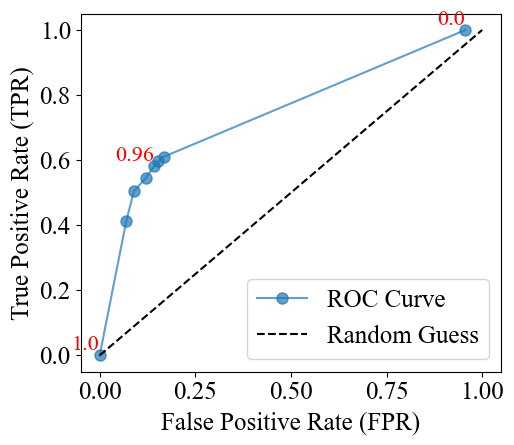

In [26]:
from plotting import plot_conf_mat, plot_ROC

y_pred_li, y_true = run_test(DATASET_PATH_REAL, DATASET_PATH_ATTACK, SPOOF_THRESHOLDS, N_REAL, N_SPOOFED)

plot_ROC(y_true, y_pred_li, SPOOF_THRESHOLDS)


### 3. Plotting a confusion matrix for each threshold

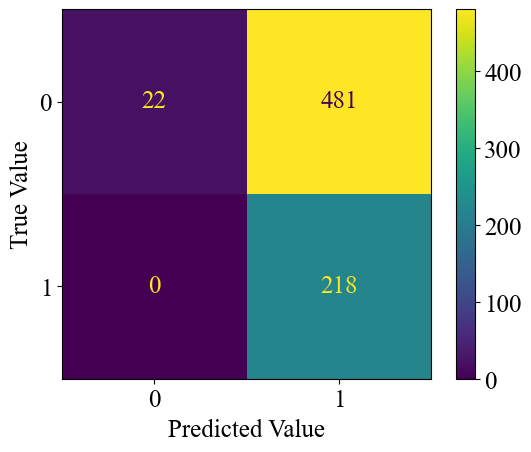

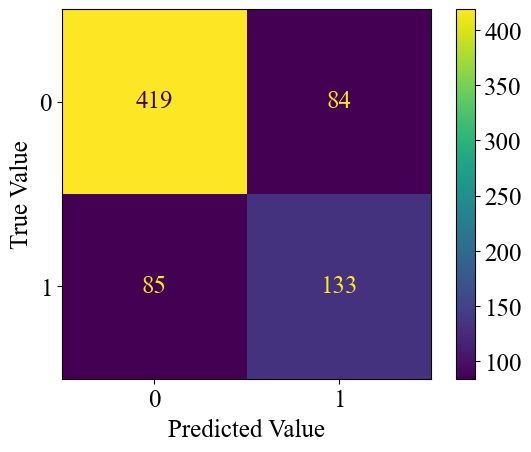

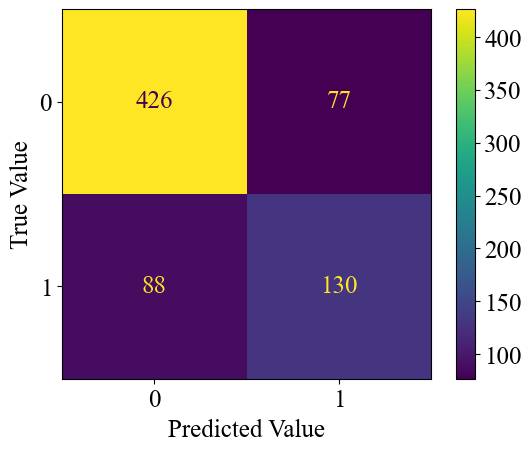

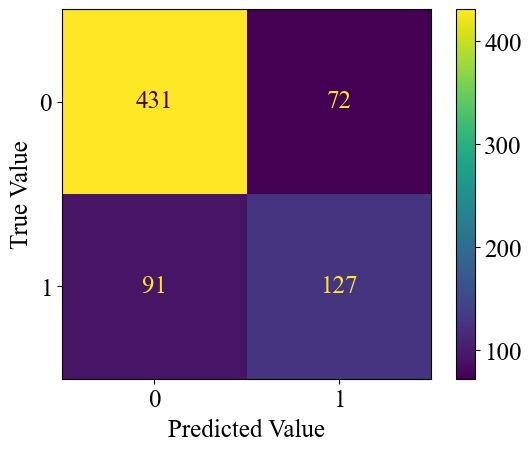

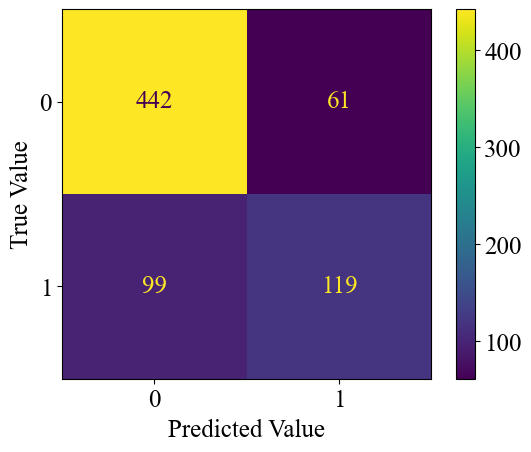

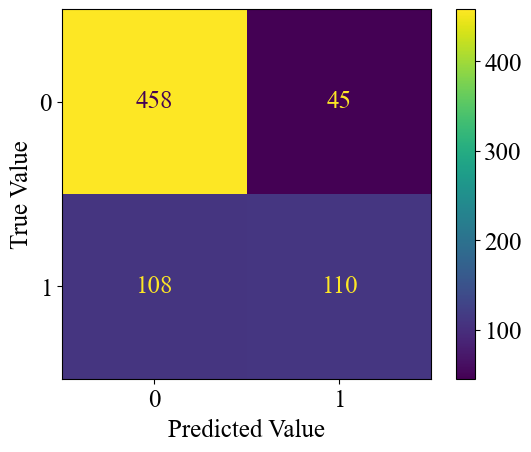

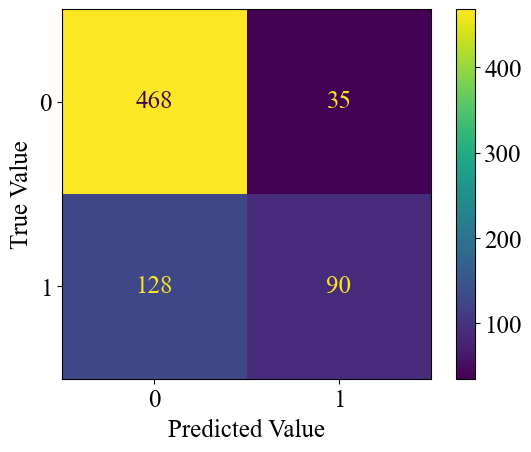

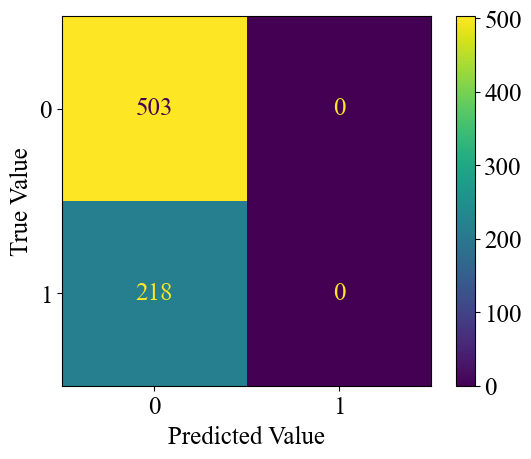

In [27]:
for y_pred in y_pred_li:
    plot_conf_mat(y_true, y_pred)